In [2]:
!pip install -q seaborn
!pip install -q optuna

In [3]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import optuna
import joblib
import matplotlib.pyplot as plt
import numpy as np
import boto3
import sagemaker
import time
from time import gmtime, strftime, sleep
from sagemaker.feature_store.feature_group import FeatureGroup

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


#### EDA

Exploratory Data Analysis Summary

This dataset provides insights into cardiovascular health with key variables like **age**, **gender**, **height**, **weight**, **BMI**, and **cardiac condition** (cardio). 

- **Age** is presented in years, covering a wide age range.
- **Gender** is encoded as 1 for **Female** and 2 for **Male**.
- **BMI** is calculated as **weight (kg) / height^2 (m)**.
- **Cardiac condition** is recorded as 0 for **no disease** and 1 for **cardiac disease**.



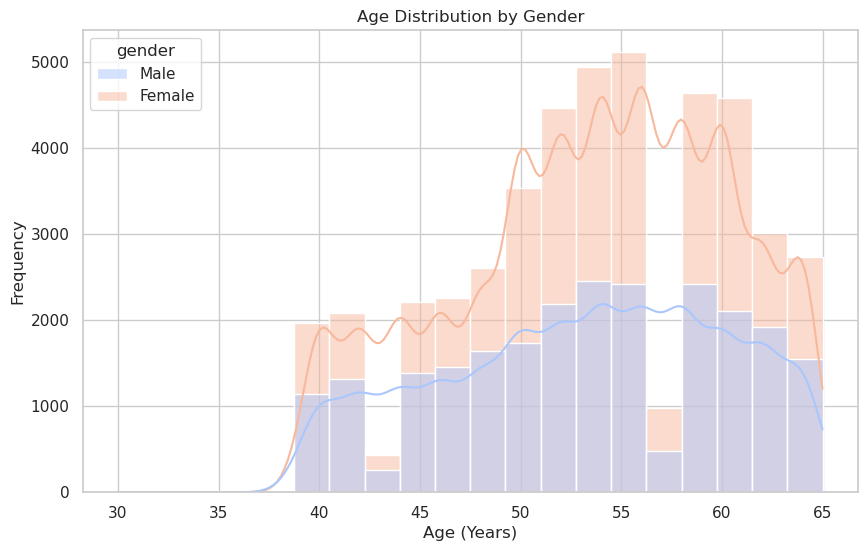

/tmp/ipykernel_130/2958890998.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='height', data=data, palette='coolwarm')


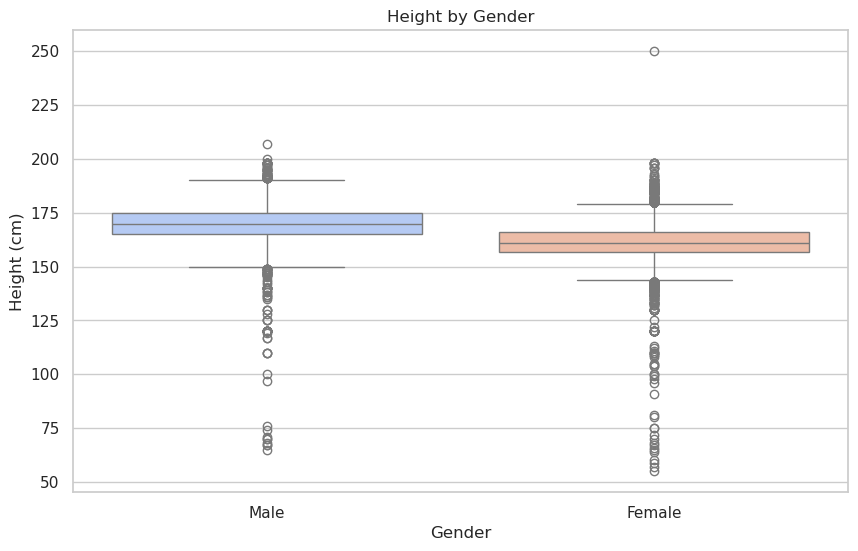

/tmp/ipykernel_130/2958890998.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='weight', data=data, palette='coolwarm')


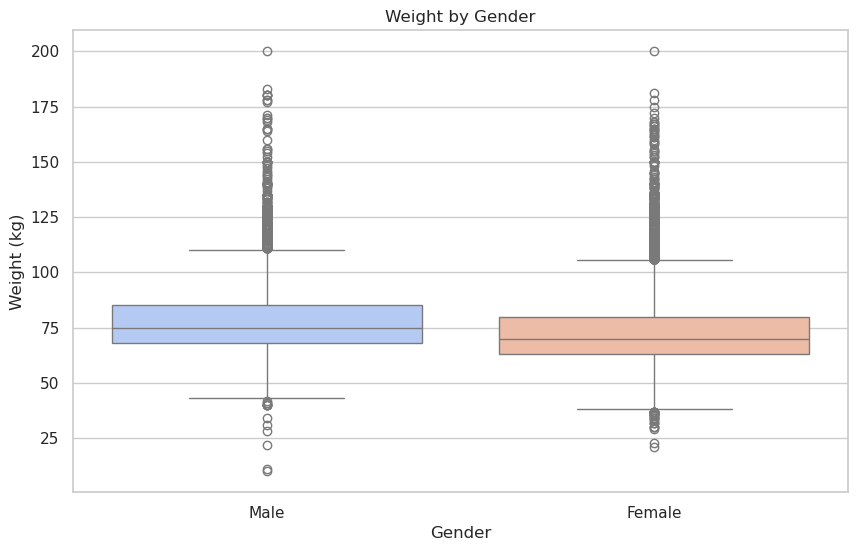

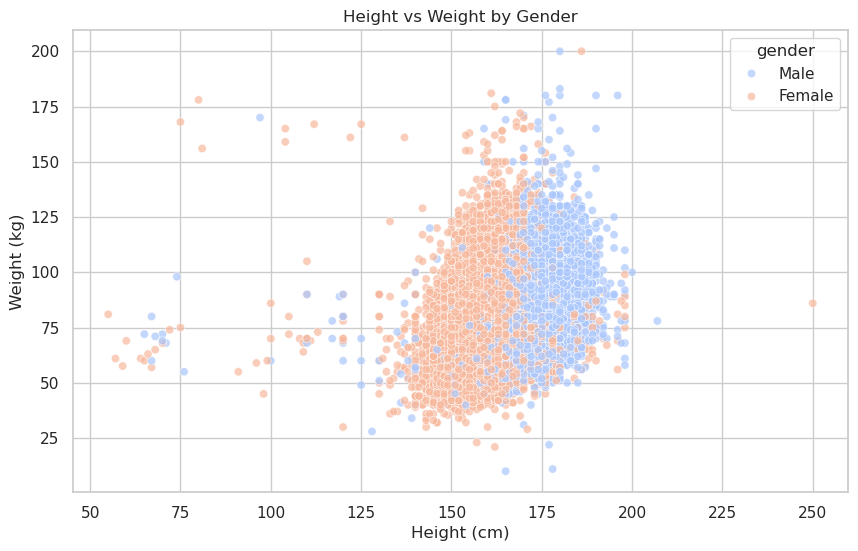

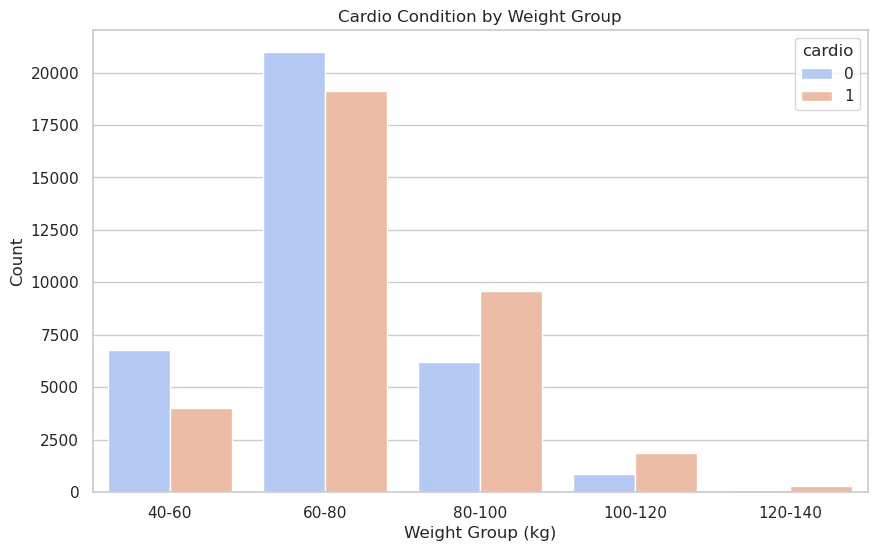

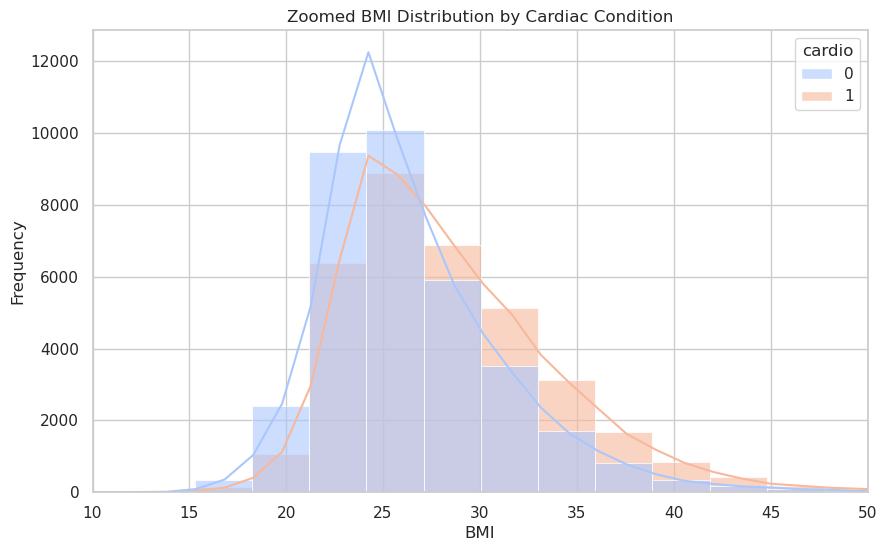

/tmp/ipykernel_130/2958890998.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='BMI_category', data=data, palette='coolwarm')


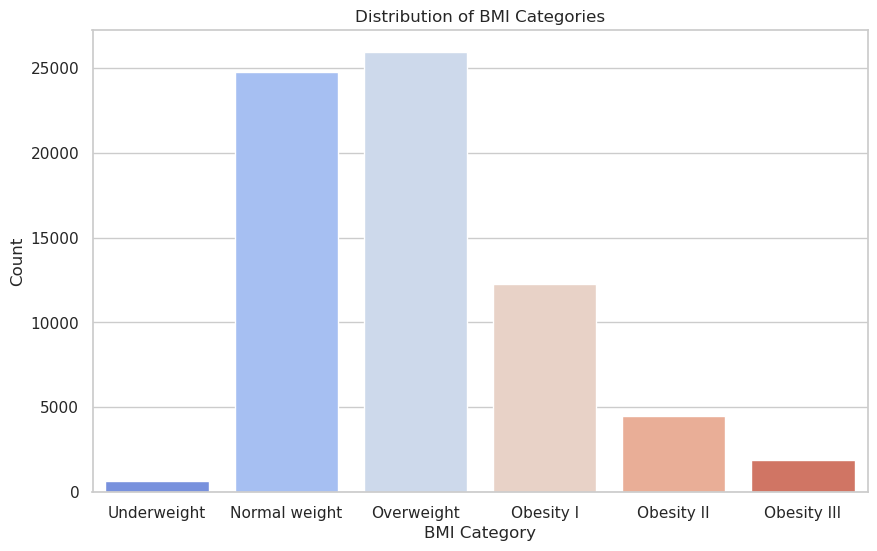

In [4]:

# Set seaborn style for beautiful visualizations
sns.set(style="whitegrid")

# Load the data
def load_data():
    return pd.read_csv('data/cardio-raw-kaggle.csv', sep=';')

data = load_data()

# Data Preprocessing
data['age_years'] = (data['age'] / 365).round().astype(int)
data['gender'] = data['gender'].map({1: 'Female', 2: 'Male'})
data['height_m'] = data['height'] / 100  # Convert height from cm to meters
data['BMI'] = data['weight'] / (data['height_m'] ** 2)

# Summary of the data
print("Exploratory Data Analysis Summary")
print("""
This dataset provides insights into cardiovascular health with key variables like **age**, **gender**, **height**, **weight**, **BMI**, and **cardiac condition** (cardio). 

- **Age** is presented in years, covering a wide age range.
- **Gender** is encoded as 1 for **Female** and 2 for **Male**.
- **BMI** is calculated as **weight (kg) / height^2 (m)**.
- **Cardiac condition** is recorded as 0 for **no disease** and 1 for **cardiac disease**.
""")

# 1. Distribution of Age with KDE Plot, differentiated by gender
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='age_years', hue='gender', kde=True, bins=20, palette='coolwarm')
plt.title('Age Distribution by Gender')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')
plt.show()

# 2. Boxplot for Height by Gender
plt.figure(figsize=(10,6))
sns.boxplot(x='gender', y='height', data=data, palette='coolwarm')
plt.title('Height by Gender')
plt.xlabel('Gender')
plt.ylabel('Height (cm)')
plt.show()

# Boxplot for Weight by Gender
plt.figure(figsize=(10,6))
sns.boxplot(x='gender', y='weight', data=data, palette='coolwarm')
plt.title('Weight by Gender')
plt.xlabel('Gender')
plt.ylabel('Weight (kg)')
plt.show()

# 3. Scatter Plot for Height vs Weight, color-coded by gender
plt.figure(figsize=(10,6))
sns.scatterplot(x='height', y='weight', hue='gender', data=data, palette='coolwarm', alpha=0.7)
plt.title('Height vs Weight by Gender')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.show()

# 4. Count of Cardio Condition by Weight Group
bins = [40, 60, 80, 100, 120, 140]
labels = ['40-60', '60-80', '80-100', '100-120', '120-140']
data['weight_group'] = pd.cut(data['weight'], bins=bins, labels=labels)

plt.figure(figsize=(10,6))
sns.countplot(x='weight_group', hue='cardio', data=data, palette='coolwarm')
plt.title('Cardio Condition by Weight Group')
plt.xlabel('Weight Group (kg)')
plt.ylabel('Count')
plt.show()

# 5. Zoomed and Granular BMI Distribution by Cardiac Condition
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='BMI', hue='cardio', kde=True, bins=100, palette='coolwarm', alpha=0.6)
plt.xlim(10, 50)
plt.title('Zoomed BMI Distribution by Cardiac Condition')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

# 6. Countplot of BMI Categories
bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf]
labels = ['Underweight', 'Normal weight', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III']
data['BMI_category'] = pd.cut(data['BMI'], bins=bins, labels=labels)

plt.figure(figsize=(10,6))
sns.countplot(x='BMI_category', data=data, palette='coolwarm')
plt.title('Distribution of BMI Categories')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.show()


#### Preprocessing / Feature Engineering

In [131]:
# Load and preprocess the dataset
print("Loading the dataset...")
file_path = r'data/cardio-raw-kaggle.csv'
df = pd.read_csv(file_path, sep=";")

print("Dataset loaded successfully. Now filling missing values with the median...")
df = df.fillna(df.median())  # Fill missing values

print("Converting 'gender' column to numeric (1=male, 2=female) as needed...")
df['gender'] = df['gender'].map({1: 0, 2: 1})  # Convert gender to numeric

Loading the dataset...
Dataset loaded successfully. Now filling missing values with the median...
Converting 'gender' column to numeric (1=male, 2=female) as needed...


#### Split Data and write locally

In [132]:
X = df.drop(columns=['cardio'])  # Features
y = df['cardio']  # Target variable

# Split into training (60%) and temporary (40%)
print("Performing initial train-temp split with 60% training and 40% temporary...")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary set into validation (50%) and test (50%) sets
print("Splitting temporary set into validation and test sets (each 20%)...")
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train, validation, and test splits completed.")
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

# Writing locally to project
pd.DataFrame(X_train).to_csv(f"data/cardio-train.csv", header=True, index=False)
pd.DataFrame(X_test).to_csv(f"data/cardio-test.csv", header=False, index=False)
pd.DataFrame(X_val).to_csv(f"data/cardio-val.csv", header=False, index=False)

# confirm format put into s3 is correct needed

Performing initial train-temp split with 60% training and 40% temporary...
Splitting temporary set into validation and test sets (each 20%)...
Train, validation, and test splits completed.
Training set size: (42000, 12)
Validation set size: (14000, 12)
Test set size: (14000, 12)


### Sagemaker CI/CD Load Data

In [4]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(service_name="sagemaker-featurestore-runtime", region_name=region)

In [5]:
# need to upload the raw data without headers
# Ideally is where data could be aggregated or eventually streamed to
file_path = r'data/cardio-raw-kaggle.csv'
df = pd.read_csv(file_path, sep=";")

df.to_csv(f"data/cardio-raw-no-header.csv", header=False, index=False)

In [192]:
# todo change path to real data in s3
local_path_train = "data/cardio-train.csv"
local_path_test = "data/cardio-test.csv"
local_path_val = "data/cardio-validation.csv"
local_path_raw = "data/cardio-raw-kaggle.csv"
local_path_raw_no_header = "data/cardio-raw-no-header.csv"

base_uri = f"s3://{bucket}/CVD-data/train"
train_input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path_train,
    desired_s3_uri=base_uri,
)
print(train_input_data_uri)

base_uri = f"s3://{bucket}/CVD-data/test"
batch_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path_test,
    desired_s3_uri=base_uri,
)
print(batch_data_uri)

base_uri = f"s3://{bucket}/CVD-data/validation"
val_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path_val,
    desired_s3_uri=base_uri,
)
print(val_data_uri)

base_uri = f"s3://{bucket}/CVD-data/raw"
raw_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path_raw_no_header,
    desired_s3_uri=base_uri,
)
print(raw_data_uri)

s3://sagemaker-us-east-1-936912055594/CVD-data/train/cardio-train.csv
s3://sagemaker-us-east-1-936912055594/CVD-data/test/cardio-test.csv
s3://sagemaker-us-east-1-936912055594/CVD-data/validation/cardio-validation.csv
s3://sagemaker-us-east-1-936912055594/CVD-data/raw/cardio-raw-no-header.csv


#### Defining pipeline parameters

In [193]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge")
model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)

# NOTE: i've under the assumption our pre processing script is to divy up any new dataset similar to ours
# For now defaulting to the raw data uri that is stored above, we can test with test data later on if need be.
# using default_value for testing
input_data = ParameterString(
    name="InputData",
    default_value=raw_data_uri,
)
batch_data = ParameterString(
    name="BatchData",
    default_value=batch_data_uri,
)
acc_threshold = ParameterFloat(name="Accuracy", default_value=0.80)

#### Create preprocessing script
this is the programatic approach to write file to code/preprocessing.py 

In [212]:
%%writefile code/preprocessing.py
import argparse
import os
import requests
import tempfile

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


# Since we get a headerless CSV file, we specify the column names here.
feature_columns_names = [
    "id",
    "age",
    "gender",
    "height",
    "weight",
    "ap_hi",
    "ap_low",
    "cholesterol",
    "gluc",
    "smoke", 
    "alco",
    "active"
]
label_column = "cardio"

categorical_features_names = [
    "gender"
]

feature_columns_dtype = {
    "id": np.float64,
    "age": np.float64,
    "gender": np.float64,
    "height": np.float64,
    "weight": np.float64,
    "ap_hi": np.float64,
    "ap_low": np.float64,
    "cholesterol": np.float64,
    "gluc": np.float64,
    "smoke": np.float64, 
    "alco": np.float64,
    "active": np.float64
}

label_column_dtype = {"cardio": np.float64}

def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z


if __name__ == "__main__":
    base_dir = "/opt/ml/processing"
    
    # Accessing the raw dataset with out headers for preprocessing
    local_path = base_dir + "/input/cardio-raw-no-header.csv"
    
    # Download the file from S3 to the local directory and convert to dataframe
    # sagemaker.s3.S3Downloader.download(s3_uri, local_path)
    df = pd.read_csv(local_path,
                     header=None,
                     names=feature_columns_names + [label_column],
                     dtype=merge_two_dicts(feature_columns_dtype, label_column_dtype))

    numeric_features = list(feature_columns_names)
    numeric_features.remove("gender")
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )

    categorical_features = ["gender"]
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    y = df.pop("cardio")
    X_pre = preprocess.fit_transform(df)
    y_pre = y.to_numpy().reshape(len(y), 1)
    print("Shape of X_pre after preprocessing:", X_pre.shape)

    combined = np.hstack((y_pre, X_pre))  # For shuffling together
    np.random.shuffle(combined)
    
    # Separate again after shuffling
    y_pre = combined[:, 0]  # Target column
    X_pre = combined[:, 1:]  # Feature columns

    # train, validation, test = np.split(X, [int(0.7 * len(X)), int(0.85 * len(X))])
    X_train, X_val, X_test = np.split(X_pre, [int(0.7 * len(X_pre)), int(0.85 * len(X_pre))])
    y_train, y_val, y_test = np.split(y_pre, [int(0.7 * len(y_pre)), int(0.85 * len(y_pre))])
    
    print("Train, validation, and test splits completed.")
    print("Training set size:", X_train.shape, " labels: ", y_train.shape)
    print("Validation set size:", X_val.shape, " labels:", y_val.shape)
    print("Test set size:", X_test.shape, " labels:", y_test.shape)

    train_combined = np.concatenate([y_train.reshape(-1, 1), X_train], axis=1)
    validation_combined = np.concatenate([y_val.reshape(-1, 1), X_val], axis=1)
    test_combined = np.concatenate([y_test.reshape(-1, 1), X_test], axis=1)

    
    # Writing locally to project
    pd.DataFrame(train_combined).to_csv(f"{base_dir}/train/train.csv", header=False, index=False)
    pd.DataFrame(test_combined).to_csv(f"{base_dir}/test/test.csv", header=True, index=False)
    pd.DataFrame(validation_combined).to_csv(f"{base_dir}/validation/validation.csv", header=False, index=False)


    pd.DataFrame(x_test).to_csv(f"{base_dir}/test-x/test-x.csv", header=False, index=False)
    pd.DataFrame(y_test).to_csv(f"{base_dir}/test-label/test-label.csv", header=True, index=False)
    # pd.DataFrame(y_val).to_csv(f"{base_dir}/validation-label/validation-label.csv", header=False, index=False)
    # pd.DataFrame(y_train).to_csv(f"{base_dir}/train-label/train-label.csv", header=False, index=False)
    # pd.DataFrame(y_test).to_csv(f"{base_dir}/test-label/test-label.csv", header=True, index=False)
    # pd.DataFrame(y_val).to_csv(f"{base_dir}/validation-label/validation-label.csv", header=False, index=False)


    # y = df.pop("cardio")
    # X_pre = preprocess.fit_transform(df)
    # y_pre = y.to_numpy().reshape(len(y), 1)

    # X = np.concatenate((y_pre, X_pre), axis=1)

    # np.random.shuffle(X)
    # train, validation, test = np.split(X, [int(0.7 * len(X)), int(0.85 * len(X))])
    

Overwriting code/preprocessing.py


In [213]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.pipeline_context import PipelineSession

framework_version = "1.2-1"
pipeline_session = PipelineSession()
model_package_group_name = f"CVDModelPackageGroupName"

# Creating Processor to use in the processing step
# instance count defaults to 1 
sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type="ml.m5.xlarge",
    instance_count=processing_instance_count,
    base_job_name="sklearn-cvd-process",
    role=role,
    sagemaker_session=pipeline_session,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [214]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

# base_dir + "data/cardio-raw-kaggle.csv"
processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
        ProcessingOutput(output_name="test-label", source="/opt/ml/processing/test-label"),
        ProcessingOutput(output_name="test-x", source="/opt/ml/processing/test-x"),
    ],
    code="code/preprocessing.py",
)

step_process = ProcessingStep(name="TransformSplitProcess", step_args=processor_args)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


#### Creating Train step to Create Model

In [215]:
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter
from sagemaker.workflow.steps import TrainingStep, TuningStep
from sagemaker.workflow.step_collections import RegisterModel
import time


# Path for model output
model_path = f"s3://{bucket}/ModelOutput"
model_name = "GradientBoosting"
# timestamp = time.strftime("%Y%m%d-%H%M")

# Image URI for model training (using xgboost for example)
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",  # Change based on the model you're using
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type=instance_type,
)

print("Building model:", model_name)
# Define the Estimator based on the selected model
if model_name == "GradientBoosting":
    # Define SageMaker Estimator (replace with LogisticRegression or GradientBoostingClassifier if needed)
    model_estimator = Estimator(
        image_uri=image_uri,
        instance_type=instance_type,
        instance_count=1,
        output_path=model_path,
        role=role,
        sagemaker_session=pipeline_session,
    )

    # Setting model hyperparamters
    model_estimator.set_hyperparameters(
        learning_rate=0.1,  
        max_depth=5,  
        num_round=100,                
    )

# Here is where we planned on setting up another estimatior for logestic regression

Building model: GradientBoosting


In [216]:
# Define the hyperparameter ranges for tuning (Optuna-like tuning in SageMaker)
hyperparameter_ranges = {
    # 'C': ContinuousParameter(0.01, 10),  # LogisticRegression C
    # 'penalty': ['l1', 'l2'],  # LogisticRegression penalty
    # 'max_iter': IntegerParameter(50, 500),  # LogisticRegression max_iter
    # 'n_estimators': IntegerParameter(50, 200),  # GradientBoosting n_estimators
    'learning_rate': ContinuousParameter(0.01, 0.5),  # GradientBoosting learning_rate
    'max_depth': IntegerParameter(3, 10),  # GradientBoosting max_depth
    'num_rounds': IntegerParameter(5, 20)
}

# Set up hyperparameter tuner for LogisticRegression and GradientBoostingClassifier
tuner = HyperparameterTuner(
    estimator=model_estimator,
    objective_metric_name='validation:accuracy',
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=[{'Name': 'accuracy', 'Regex': 'Accuracy: ([0-9\\.]+)'}],
    max_jobs=10,
    max_parallel_jobs=2
)

# Define the TuningStep
step_tuning = TuningStep(
    name="HyperparameterTuningStep",
    tuner=tuner,  # This should be your HyperparameterTuner object
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["validation"].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

In [217]:
# Optional: Register the best model (once tuning is complete) for deployment
step_register = RegisterModel(
    name="BestModelRegistration",
    estimator=model_estimator,  # Use the estimator or a derived estimator
    model_data=step_tuning.get_top_model_s3_uri(top_k=0, s3_bucket=model_path),
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.m5.large"],
    transform_instances=["ml.m5.large"],
)

In [218]:
# (Optional) Add a training step for the best model found (if necessary)
step_train = TrainingStep(
    name="BestModelTrainingStep",
    step_args=model_estimator.fit({
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv"
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["validation"].S3Output.S3Uri,
            content_type="text/csv"
        ),
    }),
)

#### Define model evalutation step

In [219]:
%%writefile code/evaluation.py
import json
import pathlib
import pickle
import tarfile

import joblib
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error

def evaluate_model(name, model, X_test, y_test):
    print(f"Evaluating model: {name}...")
    y_pred = model.predict(X_test)

    # Get probability predictions if the model supports it
    if hasattr(model, 'predict_proba'):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_pred_prob = model.decision_function(X_test)
    else:
        # For XGBoost Booster model, get probability predictions using DMatrix
        print("last else")
        y_pred_prob = y_pred


    accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
    precision = precision_score(y_test, (y_pred > 0.5).astype(int))
    recall = recall_score(y_test, (y_pred > 0.5).astype(int))
    f1 = f1_score(y_test, (y_pred > 0.5).astype(int))
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    print(f"Model {name} evaluation complete.")
    return {
        "regression_metrics": {
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "AUC": roc_auc
            # "mse": {"value": mse, "standard_deviation": std},
        }
    }

if __name__ == "__main__":
    model_path = f"/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    model = pickle.load(open("xgboost-model", "rb"))

    test_path = "/opt/ml/processing/test/test.csv"
    df = pd.read_csv(test_path, header=None)
    print("test df shape", df.shape)

    # label_path = "/opt/ml/processing/test/test-label.csv"
    # label_df = pd.read_csv(label_path, header=None)
    # print("label test df shape", label_df.shape)

    name='XGBoostModel'

    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)

    X_test = xgb.DMatrix(df.values)
    # y_test = xgb.DMatrix(label_df.values)
    
    evaluation_metrics = evaluate_model(name, model, X_test, y_test)

    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(evaluation_metrics))

Overwriting code/evaluation.py


In [220]:
# Creating processing step 
from sagemaker.processing import ScriptProcessor
from sagemaker.workflow.properties import PropertyFile

script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="script-cvd-eval",
    role=role,
    sagemaker_session=pipeline_session,
)

eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code/evaluation.py",
)

evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)

step_eval = ProcessingStep(
    name="CVDModelEval",
    step_args=eval_args,
    property_files=[evaluation_report],
)

In [221]:
# DescribeProcessingJob()
# DescribeTrainingJob()

In [222]:
from sagemaker.model import Model
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep
from sagemaker.transformer import Transformer
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep

# pull model from artifactory 
model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

# create step to run model
step_create_model = ModelStep(
    name="CVDCreateModel",
    step_args=model.create(instance_type="ml.m5.large", accelerator_type="ml.eia1.medium"),
)

# create trasformed data
transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    output_path=f"s3://{bucket}/CVDTransformBatch",
)

step_transform = TransformStep(
    name="CVDTransformBatch", transformer=transformer, 
    inputs=TransformInput(data=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
                          content_type="text/csv") 
)

In [223]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    # approval_status=model_approval_status,
    model_metrics=model_metrics,
)
step_register = ModelStep(name="CVDRegisterModel", step_args=register_args)

#### Fail step

In [224]:
# probably have to change metrics to 
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join


step_fail = FailStep(
    name="ModelAccuracyFail",
    error_message=Join(on=" ", values=["Execution failed due to Accuracy >", acc_threshold]),
)

#### Creating conditional stepss

In [225]:
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

cond_lte = ConditionLessThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="regression_metrics.Accuracy",
    ).expr,
    right=acc_threshold,
)

print(cond_lte)

step_cond = ConditionStep(
    name="AccuracyCondionStep",
    conditions=[cond_lte],
    if_steps=[step_register, step_create_model, step_transform],
    else_steps=[step_fail],
)

ConditionLessThanOrEqualTo(condition_type=<ConditionTypeEnum.LTE: 'LessThanOrEqualTo'>, left={'Std:JsonGet': {'PropertyFile': {'Get': 'Steps.CVDModelEval.PropertyFiles.EvaluationReport'}, 'Path': 'regression_metrics.Accuracy'}}, right=ParameterFloat(name='Accuracy', parameter_type=<ParameterTypeEnum.FLOAT: 'Float'>, default_value=0.8))


#### Defining Full Pipeline

In [226]:
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

import json

pipeline_name = f"CVD-GradientBoost-Pipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        instance_type,
        model_approval_status,
        input_data,
        batch_data,
        acc_threshold,
    ],
    steps=[step_process, step_train, step_eval, step_cond],
)

# Examine pipeline
definition = json.loads(pipeline.definition())
print(definition)

{'Version': '2020-12-01', 'Metadata': {}, 'Parameters': [{'Name': 'ProcessingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1}, {'Name': 'TrainingInstanceType', 'Type': 'String', 'DefaultValue': 'ml.m5.xlarge'}, {'Name': 'ModelApprovalStatus', 'Type': 'String', 'DefaultValue': 'PendingManualApproval'}, {'Name': 'InputData', 'Type': 'String', 'DefaultValue': 's3://sagemaker-us-east-1-936912055594/CVD-data/raw/cardio-raw-no-header.csv'}, {'Name': 'BatchData', 'Type': 'String', 'DefaultValue': 's3://sagemaker-us-east-1-936912055594/CVD-data/test/cardio-test.csv'}, {'Name': 'Accuracy', 'Type': 'Float', 'DefaultValue': 0.8}], 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'}, 'TrialName': {'Get': 'Execution.PipelineExecutionId'}}, 'Steps': [{'Name': 'TransformSplitProcess', 'Type': 'Processing', 'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.m5.xlarge', 'InstanceCount': {'Get': 'Parameters.ProcessingInstanceCount'}, 'VolumeSize

In [227]:
# submit and upload pipeline
pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:936912055594:pipeline/CVD-GradientBoost-Pipeline',
 'ResponseMetadata': {'RequestId': 'c0418aea-e198-4fc9-a0b7-c065daf4151a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c0418aea-e198-4fc9-a0b7-c065daf4151a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '94',
   'date': 'Mon, 28 Oct 2024 05:47:30 GMT'},
  'RetryAttempts': 0}}

In [228]:
execution = pipeline.start()

In [229]:
print(execution.describe())
print("-----------")
print(execution.list_steps())

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:936912055594:pipeline/CVD-GradientBoost-Pipeline', 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:936912055594:pipeline/CVD-GradientBoost-Pipeline/execution/z7u04gervhyg', 'PipelineExecutionDisplayName': 'execution-1730094451133', 'PipelineExecutionStatus': 'Executing', 'PipelineExperimentConfig': {'ExperimentName': 'cvd-gradientboost-pipeline', 'TrialName': 'z7u04gervhyg'}, 'CreationTime': datetime.datetime(2024, 10, 28, 5, 47, 31, 81000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2024, 10, 28, 5, 47, 31, 81000, tzinfo=tzlocal()), 'CreatedBy': {'IamIdentity': {'Arn': 'arn:aws:sts::936912055594:assumed-role/LabRole/SageMaker', 'PrincipalId': 'AROA5UJCPNUVM4RORLTYL:SageMaker'}}, 'LastModifiedBy': {'IamIdentity': {'Arn': 'arn:aws:sts::936912055594:assumed-role/LabRole/SageMaker', 'PrincipalId': 'AROA5UJCPNUVM4RORLTYL:SageMaker'}}, 'ResponseMetadata': {'RequestId': '48fca12e-4398-49ed-98d8-26c9a1d92ec0', 'HTTPStatusCode': 20

In [230]:
execution.wait()

WaiterError: Waiter PipelineExecutionComplete failed: Waiter encountered a terminal failure state: For expression "PipelineExecutionStatus" we matched expected path: "Failed"

In [ ]:
# Examine evalutation report
from pprint import pprint

evaluation_json = sagemaker.s3.S3Downloader.read_file(
    "{}/evaluation.json".format(
        step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
    )
)
pprint(json.loads(evaluation_json))

In [ ]:
# Review lineage of artificats

import time
from sagemaker.lineage.visualizer import LineageTableVisualizer


viz = LineageTableVisualizer(sagemaker.session.Session())
for execution_step in reversed(execution.list_steps()):
    print(execution_step)
    display(viz.show(pipeline_execution_step=execution_step))
    time.sleep(5)

In [ ]:
# Parameterized executions
execution = pipeline.start(
    parameters=dict(
        ModelApprovalStatus="Approved",
    )
)

#  OR
# execution = pipeline.start(parameters=dict(MseThreshold=3.0))

In [ ]:
try:
    execution.wait()
except Exception as error:
    print(error)

In [ ]:
execution.list_steps()

### AWS Config to Create Feature Store

#### Define feature group

In [16]:
patient_feature_group_name = "patient-feature-group-" + strftime("%d-%H-%M-%S", gmtime())

patient_feature_group = FeatureGroup(
    name=patient_feature_group_name, sagemaker_session=sess
)

def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if pd.api.types.is_object_dtype(data_frame[label]):
            data_frame[label] = data_frame[label].astype("string")
    return data_frame

final_df = cast_object_to_string(X)

record_identifier_feature_name = "id"
event_time_feature_name = "event_time" # needed for FEATURE GROUP
current_time_sec = int(round(time.time()))
final_df[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(X), dtype="float64"
)

final_df['event_time'] = final_df['event_time'].fillna(current_time_sec)

display(final_df.head())
# Load feature definitions into the feature group
patient_feature_group.load_feature_definitions(data_frame=final_df)

0


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,event_time
0,0,18393,1,168,62.0,110,80,1,1,0,0,1,1.729433e+09
1,1,20228,0,156,85.0,140,90,3,1,0,0,1,1.729433e+09
2,2,18857,0,165,64.0,130,70,3,1,0,0,0,1.729433e+09
3,3,17623,1,169,82.0,150,100,1,1,0,0,1,1.729433e+09
4,4,17474,0,156,56.0,100,60,1,1,0,0,0,1.729433e+09


[FeatureDefinition(feature_name='id', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='age', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='gender', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='height', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='weight', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='ap_hi', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='ap_lo', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='cholesterol', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='gluc', feature_type=<Fe

#### Create feature group in sagemaker feature store

In [17]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

s3_private_data_path = "s3://{}/feature_groups/".format(bucket)

patient_feature_group.create(
    s3_uri= s3_private_data_path,
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=patient_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup patient-feature-group-20-14-05-03 successfully created.


In [18]:
# Validate feature group
patient_feature_group.describe()
sagemaker_client.list_feature_groups()

{'FeatureGroupSummaries': [{'FeatureGroupName': 'patient-feature-group-20-14-05-03',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:768009566519:feature-group/patient-feature-group-20-14-05-03',
   'CreationTime': datetime.datetime(2024, 10, 20, 14, 5, 8, 598000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created'}],
 'ResponseMetadata': {'RequestId': '18a788c1-b336-41c6-99f2-30712d60dcf2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '18a788c1-b336-41c6-99f2-30712d60dcf2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '256',
   'date': 'Sun, 20 Oct 2024 14:05:43 GMT'},
  'RetryAttempts': 0}}

In [28]:
import time
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup
import pandas as pd
import tqdm

# Assuming 'final_df' is your DataFrame and 'patient_feature_group' is your feature group

# Improved ingestion approach
def batch_ingest(feature_group, data_frame, batch_size=1000, max_workers=10):
    num_records = len(data_frame)
    for start in tqdm.tqdm(range(0, num_records, batch_size), desc="Ingesting records", unit="batch"):
        end = min(start + batch_size, num_records)
        batch_df = data_frame.iloc[start:end]
        feature_group.ingest(data_frame=batch_df, max_workers=max_workers, wait=False)
        print(f"Ingested records from {start} to {end}")
        time.sleep(1)  # Optional: Add a short delay to avoid overwhelming the system

# Example usage
# patient_feature_group = FeatureGroup(name='your_feature_group_name', sagemaker_session=sagemaker.Session())
# batch_ingest(patient_feature_group, final_df, batch_size=500, max_workers=15)

# If you want to add a message to indicate the script is running, you can use:
print("Running the ingestion script...")

# To catch any potential errors, you can use try-except blocks:
try:
    # Run the batch ingestion function here
    pass  # Replace with the actual function call
except Exception as e:
    print(f"Failed to execute ingestion script: {e}")



Running the ingestion script...


In [29]:
# retreive a record from the online store
# Should be: 0	0	18393	1	168	62.0	110	80	1	1	0	0	1
record_identifier_value = '0'

featurestore_runtime.get_record(
    FeatureGroupName=patient_feature_group_name,
    RecordIdentifierValueAsString=record_identifier_value,
)

{'ResponseMetadata': {'RequestId': '5b0ea7cd-7284-4e33-994c-32cf32cce5aa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5b0ea7cd-7284-4e33-994c-32cf32cce5aa',
   'content-type': 'application/json',
   'content-length': '957',
   'date': 'Sun, 20 Oct 2024 14:23:40 GMT'},
  'RetryAttempts': 0},
 'Record': [{'FeatureName': 'id', 'ValueAsString': '0'},
  {'FeatureName': 'age', 'ValueAsString': '18393'},
  {'FeatureName': 'gender', 'ValueAsString': '1'},
  {'FeatureName': 'height', 'ValueAsString': '168'},
  {'FeatureName': 'weight', 'ValueAsString': '62.0'},
  {'FeatureName': 'ap_hi', 'ValueAsString': '110'},
  {'FeatureName': 'ap_lo', 'ValueAsString': '80'},
  {'FeatureName': 'cholesterol', 'ValueAsString': '1'},
  {'FeatureName': 'gluc', 'ValueAsString': '1'},
  {'FeatureName': 'smoke', 'ValueAsString': '0'},
  {'FeatureName': 'alco', 'ValueAsString': '0'},
  {'FeatureName': 'active', 'ValueAsString': '1'},
  {'FeatureName': 'event_time', 'ValueAsString': '1729433104.0

In [30]:
# Clean up feature group
patient_feature_group.delete()

#### Create Model Cards

In [31]:
import json
from datetime import date

def create_model_card(model_name, model_description, intended_use, limitations, performance_metrics, ethical_considerations, training_data, evaluation_data):
    """
    Generates a model card with key information about the model.
    
    Args:
    model_name (str): The name of the model.
    model_description (str): A brief description of the model.
    intended_use (str): Description of the intended uses of the model.
    limitations (str): Known limitations of the model.
    performance_metrics (dict): A dictionary of performance metrics.
    ethical_considerations (str): Ethical considerations taken into account.
    training_data (str): Information about the training dataset.
    evaluation_data (str): Information about the evaluation dataset.
    
    Returns:
    model_card (dict): A dictionary representation of the model card.
    """
    model_card = {
        "Model Name": model_name,
        "Description": model_description,
        "Date": str(date.today()),
        "Intended Use": intended_use,
        "Limitations": limitations,
        "Performance Metrics": performance_metrics,
        "Ethical Considerations": ethical_considerations,
        "Training Data": training_data,
        "Evaluation Data": evaluation_data
    }
    
    # Save the model card as a JSON file for documentation
    with open(f'{model_name}_model_card.json', 'w') as file:
        json.dump(model_card, file, indent=4)
    
    return model_card


# Example usage based on PDF project
model_name = "Cardiovascular Disease Prediction Model"
model_description = """
A model that predicts the risk of cardiovascular disease based on patient demographic and health information. 
Key features include age, gender, BMI, cholesterol, and glucose levels.
"""
intended_use = """
This model is intended to help healthcare providers identify patients at high risk for cardiovascular disease, 
to support early intervention and treatment planning.
"""
limitations = """
This model may not generalize well to populations outside the training dataset or to rare, less common cases.
Performance might degrade with insufficient data or noisy features.
"""
performance_metrics = {
    "Accuracy": 0.87,
    "Precision": 0.85,
    "Recall": 0.80,
    "F1-Score": 0.83,
    "ROC AUC": 0.88
}
ethical_considerations = """
There may be biases in the dataset, especially with underrepresented groups in healthcare.
Fairness evaluations should be performed to ensure equity across different demographics.
"""
training_data = "Training dataset consists of 60% of the total cardiovascular dataset. The dataset includes over 70,000 records."
evaluation_data = "Evaluation was performed using 20% of the dataset reserved for testing. A 5-fold cross-validation was also used."

# Generate the model card
model_card = create_model_card(model_name, model_description, intended_use, 
                               limitations, performance_metrics, ethical_considerations, 
                               training_data, evaluation_data)

# Print the generated model card
print(json.dumps(model_card, indent=4))


{
    "Model Name": "Cardiovascular Disease Prediction Model",
    "Description": "\nA model that predicts the risk of cardiovascular disease based on patient demographic and health information. \nKey features include age, gender, BMI, cholesterol, and glucose levels.\n",
    "Date": "2024-10-20",
    "Intended Use": "\nThis model is intended to help healthcare providers identify patients at high risk for cardiovascular disease, \nto support early intervention and treatment planning.\n",
    "Limitations": "\nThis model may not generalize well to populations outside the training dataset or to rare, less common cases.\nPerformance might degrade with insufficient data or noisy features.\n",
    "Performance Metrics": {
        "Accuracy": 0.87,
        "Precision": 0.85,
        "Recall": 0.8,
        "F1-Score": 0.83,
        "ROC AUC": 0.88
    },
    "Ethical Considerations": "\nThere may be biases in the dataset, especially with underrepresented groups in healthcare.\nFairness evalua

### Configure CloudWatch 

 A-Set Up CloudWatch Logs and Metrics for SageMaker

In [32]:
import boto3

# Create a CloudWatch client
cloudwatch = boto3.client('cloudwatch')

# Create a log group for SageMaker (if not already existing)
log_group_name = '/aws/sagemaker/TrainingJobs'

# Create a log group
logs_client = boto3.client('logs')
try:
    logs_client.create_log_group(logGroupName=log_group_name)
    print(f"Log group '{log_group_name}' created successfully.")
except logs_client.exceptions.ResourceAlreadyExistsException:
    print(f"Log group '{log_group_name}' already exists.")

# Function to create a CloudWatch alarm
def create_cloudwatch_alarm(alarm_name, metric_name, namespace, threshold, comparison_operator, evaluation_periods, period, statistic):
    try:
        response = cloudwatch.put_metric_alarm(
            AlarmName=alarm_name,
            MetricName=metric_name,
            Namespace=namespace,
            Threshold=threshold,
            ComparisonOperator=comparison_operator,
            EvaluationPeriods=evaluation_periods,
            Period=period,
            Statistic=statistic,
            ActionsEnabled=False  # Set to True and specify actions if needed
        )
        print(f"CloudWatch alarm '{alarm_name}' created successfully.")
    except Exception as e:
        print(f"Failed to create CloudWatch alarm: {str(e)}")

# Example: Create a CloudWatch alarm for monitoring training job duration
create_cloudwatch_alarm(
    alarm_name='SageMakerTrainingJobDurationAlarm',
    metric_name='TrainingJobDuration',
    namespace='AWS/SageMaker',
    threshold=3600,  # For example, trigger if training exceeds 1 hour
    comparison_operator='GreaterThanThreshold',
    evaluation_periods=1,
    period=300,  # 5 minutes
    statistic='Average'
)

# Example: Create a CloudWatch alarm for model accuracy below a threshold
create_cloudwatch_alarm(
    alarm_name='SageMakerModelAccuracyAlarm',
    metric_name='ValidationAccuracy',
    namespace='AWS/SageMaker',
    threshold=0.80,  # For example, trigger if accuracy falls below 80%
    comparison_operator='LessThanThreshold',
    evaluation_periods=1,
    period=300,  # 5 minutes
    statistic='Average'
)


Log group '/aws/sagemaker/TrainingJobs' already exists.
CloudWatch alarm 'SageMakerTrainingJobDurationAlarm' created successfully.
CloudWatch alarm 'SageMakerModelAccuracyAlarm' created successfully.


B-Custom Metrics for SageMaker 

In [34]:
import boto3

# Create a CloudWatch client
cloudwatch = boto3.client('cloudwatch')

# Function to send custom metrics to CloudWatch
def put_custom_metric(metric_name, namespace, value, unit='None'):
    try:
        cloudwatch.put_metric_data(
            Namespace=namespace,  # Namespace should be here, outside MetricData
            MetricData=[
                {
                    'MetricName': metric_name,
                    'Value': value,
                    'Unit': unit
                },
            ]
        )
        print(f"Custom metric '{metric_name}' sent to CloudWatch under namespace '{namespace}'.")
    except Exception as e:
        print(f"Failed to send custom metric: {str(e)}")

# Example: Send a custom metric for a model's training duration
put_custom_metric(
    metric_name='TrainingDurationCustom',
    namespace='Custom/SageMaker',
    value=3600  # Duration in seconds
)


Custom metric 'TrainingDurationCustom' sent to CloudWatch under namespace 'Custom/SageMaker'.


#### Create and upload baseline Metrics

In [36]:
import json
import boto3

# Define your baseline metrics (example)
baseline_metrics = {
    "classification_metrics": {
        "accuracy": {"value": 0.92},
        "precision": {"value": 0.88},
        "recall": {"value": 0.85},
        "f1_score": {"value": 0.86},
        "roc_auc": {"value": 0.90}
    }
}

# Save the baseline metrics as a JSON file
baseline_file_path = "/tmp/baseline_metrics.json"
with open(baseline_file_path, "w") as f:
    json.dump(baseline_metrics, f)

print(f"Baseline metrics saved to {baseline_file_path}")

Baseline metrics saved to /tmp/baseline_metrics.json


#### Setup Monitoring Metrics

In [39]:
import json
import boto3

# Define your baseline metrics (example)
baseline_metrics = {
    "classification_metrics": {
        "accuracy": {"value": 0.92},
        "precision": {"value": 0.88},
        "recall": {"value": 0.85},
        "f1_score": {"value": 0.86},
        "roc_auc": {"value": 0.90}
    }
}

# Save the baseline metrics as a JSON file
baseline_file_path = "/tmp/baseline_metrics.json"
with open(baseline_file_path, "w") as f:
    json.dump(baseline_metrics, f)

print(f"Baseline metrics saved to {baseline_file_path}")

# Initialize S3 client
s3 = boto3.client('s3')

# Define your S3 bucket and path (use one of your available buckets)
bucket_name = 'sagemaker-us-east-1-768009566519'
s3_baseline_path = 'baselines/baseline_metrics.json'

# Upload baseline metrics to S3
try:
    s3.upload_file(baseline_file_path, bucket_name, s3_baseline_path)
    print(f"Baseline metrics uploaded to s3://{bucket_name}/{s3_baseline_path}")
except Exception as e:
    print(f"Failed to upload baseline metrics: {str(e)}")



Baseline metrics saved to /tmp/baseline_metrics.json
Baseline metrics uploaded to s3://sagemaker-us-east-1-768009566519/baselines/baseline_metrics.json
